In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resume-dataset/UpdatedResumeDataSet.csv


In [12]:
df=pd.read_csv('/kaggle/input/resume-dataset/UpdatedResumeDataSet.csv')
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [13]:
df.shape

(962, 2)

In [14]:
df['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [15]:
df.dtypes

Category    object
Resume      object
dtype: object

In [16]:
df['Category'].value_counts()

Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Sales                        40
Data Science                 40
Mechanical Engineer          40
ETL Developer                40
Blockchain                   40
Operations Manager           40
Arts                         36
Database                     33
Health and fitness           30
PMO                          30
Electrical Engineering       30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: count, dtype: int64

In [17]:
import re

def clean_text(text):
    # Remove special characters and extra spaces
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    text = re.sub(r'[^a-zA-Z0-9.,!?\- ]', '', text)  # Remove non-alphanumeric characters except punctuation
    text = text.strip().lower()  # Convert to lowercase
    return text

# Apply cleaning function
df['Cleaned_Resume'] = df['Resume'].astype(str).apply(clean_text)

# Save cleaned dataset
df.to_csv("Cleaned_ResumeDataSet.csv", index=False)

print("Text preprocessing complete. Cleaned dataset saved as 'Cleaned_ResumeDataSet.csv'")


Text preprocessing complete. Cleaned dataset saved as 'Cleaned_ResumeDataSet.csv'


In [18]:
df.head()

,Category,Resume,Cleaned_Resume
0,Data Science,Skills * Programming Languages: Python (pandas...,"skills programming languages python pandas, n..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education details may 2013 to may 2017 b.e uit...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...","areas of interest deep learning, control syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skills r python sap hana tableau sap hana...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...","education details mca ymcaust, faridabad, hary..."


# EDA

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


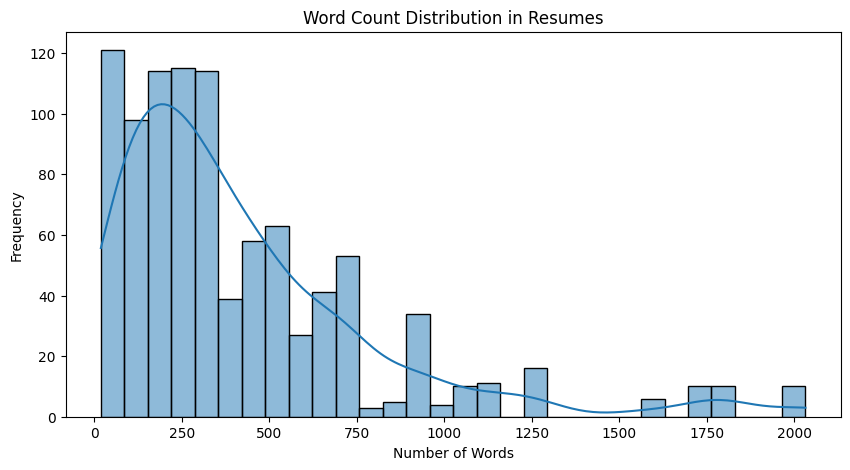

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Word Count Distribution
df['Word_Count'] = df['Cleaned_Resume'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(df['Word_Count'], bins=30, kde=True)
plt.title("Word Count Distribution in Resumes")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

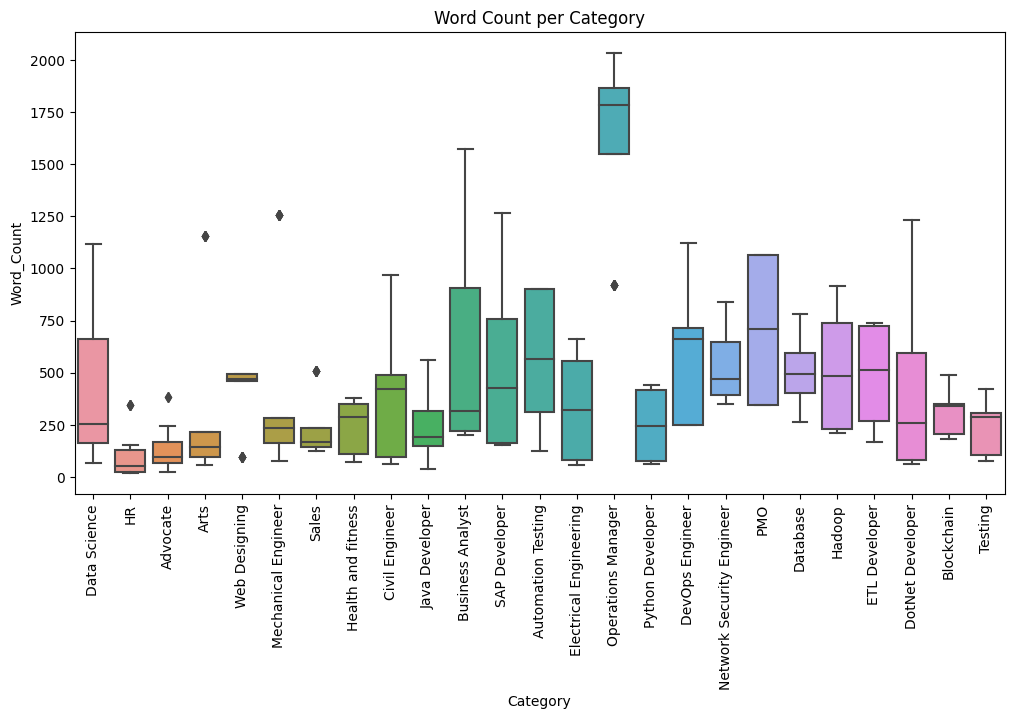

In [20]:
# Category-wise Word Count
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Word_Count', data=df)
plt.xticks(rotation=90)
plt.title("Word Count per Category")
plt.show()

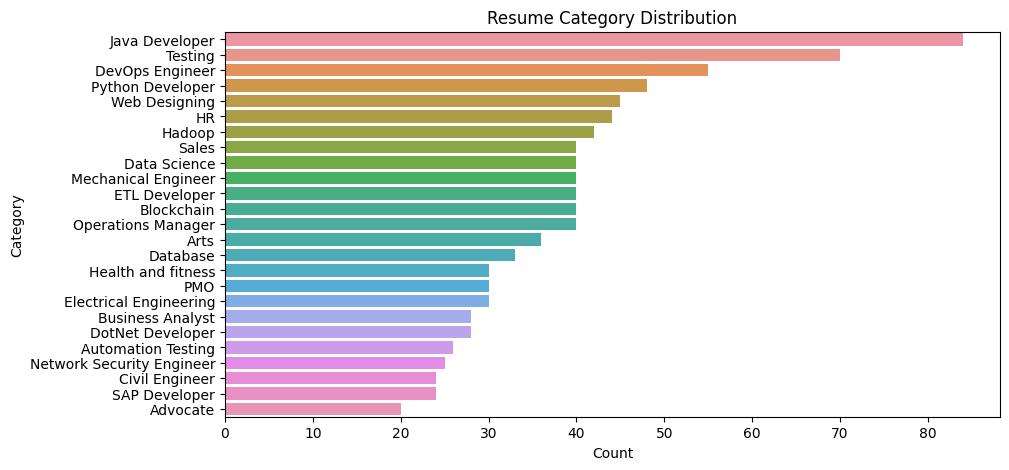

In [21]:
# Class Balance
plt.figure(figsize=(10, 5))
sns.countplot(y=df['Category'], order=df['Category'].value_counts().index)
plt.title("Resume Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

# Model Training

In [ ]:
!pip install evaluate

In [30]:
df.columns

Index(['Category', 'Resume', 'Cleaned_Resume', 'Word_Count', 'Label'], dtype='object')

In [31]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Split into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Cleaned_Resume"], df["Label"], test_size=0.2, stratify=df["Label"]
)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize text data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": list(train_labels)
})

val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": list(val_labels)
})


In [42]:
# Load pre-trained BERT for classification
num_labels = len(df["Label"].unique())  # Auto-detect number of classes
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",  # Enable logging per epoch
    report_to="none",
    load_best_model_at_end=True,
    fp16=True if torch.cuda.is_available() else False
)

# Set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [43]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.916500,2.284551
2,1.753600,1.103470
3,0.898300,0.585670
4,0.554100,0.436106


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=196, training_loss=1.5306274842242806, metrics={'train_runtime': 222.6322, 'train_samples_per_second': 13.817, 'train_steps_per_second': 0.88, 'total_flos': 809496739098624.0, 'train_loss': 1.5306274842242806, 'epoch': 4.0})

In [44]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.4361056089401245,
 'eval_runtime': 3.5484,
 'eval_samples_per_second': 54.391,
 'eval_steps_per_second': 3.664,
 'epoch': 4.0}

In [46]:
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }

trainer.evaluate()


{'eval_loss': 0.4361056089401245,
 'eval_runtime': 3.9283,
 'eval_samples_per_second': 49.13,
 'eval_steps_per_second': 3.309,
 'epoch': 4.0}

**Old Model**

In [35]:
model.save_pretrained("resume_classifier")
tokenizer.save_pretrained("resume_classifier")

('resume_classifier/tokenizer_config.json',
 'resume_classifier/special_tokens_map.json',
 'resume_classifier/vocab.txt',
 'resume_classifier/added_tokens.json')

**Best (new) Model**

In [47]:
trainer.save_model("bert_resume_classifier")
tokenizer.save_pretrained("bert_resume_classifier")


('bert_resume_classifier/tokenizer_config.json',
 'bert_resume_classifier/special_tokens_map.json',
 'bert_resume_classifier/vocab.txt',
 'bert_resume_classifier/added_tokens.json')

# Testing

In [67]:
from transformers import BertForSequenceClassification, BertTokenizer

model_path = "bert_resume_classifier"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Test on new input
text = "Experienced data scientist with Python and machine learning expertise."
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)

print(outputs)


SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0354, -0.3180, -0.1431, -0.1498, -0.6989, -0.1169,  3.2147, -1.0363,
          0.3863, -0.5611,  0.2084, -0.5612,  0.5036,  0.5605,  0.0747,  0.3974,
         -0.8701, -0.2375, -1.3204, -0.7389,  2.6419,  0.0546, -0.3866, -0.6685,
         -0.6817]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [60]:
unique_labels = df[['Label', 'Category']].drop_duplicates().sort_values('Label')
print(unique_labels)


     Label                   Category
84       0                   Advocate
104      1                       Arts
455      2         Automation Testing
852      3                 Blockchain
403      4           Business Analyst
295      5             Civil Engineer
0        6               Data Science
709      7                   Database
599      8            DevOps Engineer
824      9           DotNet Developer
784     10              ETL Developer
481     11     Electrical Engineering
40      12                         HR
742     13                     Hadoop
265     14         Health and fitness
319     15             Java Developer
185     16        Mechanical Engineer
654     17  Network Security Engineer
511     18         Operations Manager
679     19                        PMO
551     20           Python Developer
431     21              SAP Developer
225     22                      Sales
892     23                    Testing
140     24              Web Designing


In [66]:
import torch.nn.functional as F

logits = torch.tensor([[ 0.0354, -0.3180, -0.1431, -0.1498, -0.6989, -0.1169,  
                        3.2147, -1.0363, 0.3863, -0.5611, 0.2084, -0.5612,  
                        0.5036, 0.5605, 0.0747, 0.3974, -0.8701, -0.2375,  
                        -1.3204, -0.7389, 2.6419, 0.0546, -0.3866, -0.6685,  
                        -0.6817]])

probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
predicted_class = torch.argmax(probs, dim=1).item()  # Get the predicted class index

label_map = {
    0: "Advocate", 1: "Arts", 2: "Automation Testing", 3: "Blockchain",
    4: "Business Analyst", 5: "Civil Engineer", 6: "Data Science", 7: "Database",
    8: "DevOps Engineer", 9: "DotNet Developer", 10: "ETL Developer",
    11: "Electrical Engineering", 12: "HR", 13: "Hadoop", 14: "Health and fitness",
    15: "Java Developer", 16: "Mechanical Engineer", 17: "Network Security Engineer",
    18: "Operations Manager", 19: "PMO", 20: "Python Developer",
    21: "SAP Developer", 22: "Sales", 23: "Testing", 24: "Web Designing"
}

predicted_category = label_map[predicted_class]
print(f"Predicted Category: {predicted_category}")

Predicted Category: Data Science


# Interface

In [69]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 MB 30.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 82.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
'''
import gradio as gr
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load fine-tuned model & tokenizer
model_path = "bert_resume_classifier"  # Change if saved elsewhere
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Label mapping
label_map = {
    0: "Advocate", 1: "Arts", 2: "Automation Testing", 3: "Blockchain",
    4: "Business Analyst", 5: "Civil Engineer", 6: "Data Science", 7: "Database",
    8: "DevOps Engineer", 9: "DotNet Developer", 10: "ETL Developer",
    11: "Electrical Engineering", 12: "HR", 13: "Hadoop", 14: "Health and fitness",
    15: "Java Developer", 16: "Mechanical Engineer", 17: "Network Security Engineer",
    18: "Operations Manager", 19: "PMO", 20: "Python Developer",
    21: "SAP Developer", 22: "Sales", 23: "Testing", 24: "Web Designing"
}

# Prediction Function
def predict_resume_category(resume_text):
    inputs = tokenizer(resume_text, truncation=True, padding=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return f"Predicted Job Category: {label_map[predicted_class]}"

# Gradio Interface
iface = gr.Interface(
    fn=predict_resume_category,
    inputs=gr.Textbox(lines=10, placeholder="Paste resume text here..."),
    outputs="text",
    title="Resume Job Category Predictor",
    description="Enter resume text to classify the job category using BERT.",
)

# Launch
iface.launch(share=True)  # Use share=True to get a public Gradio link
'''